                   
#Classificazione degli stadi di cirrosi epatica 🩺
<br>
Progetto per l'esame di Programmazione di applicazioni di Data Intensive.
<br><br>Candoli Francesco
<br>francesco.candoli@studio.unibo.it
<br>0001019894

Il presente progetto si propone di sviluppare un sistema di classificazione in grado di predire lo stadio della cirrosi epatica di un paziente utilizzando dati clinici e di laboratorio. Per raggiungere questo obiettivo, verranno esplorati e confrontati diversi modelli di classificazione.

##Caricamento librerie

In [3]:
#Utility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Data splitting
from sklearn.model_selection import train_test_split

#Classification models
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

#Model evaluation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from mlxtend.evaluate import mcnemar_table, mcnemar

#Pipeline utility
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

##Caricamento dei dati

###Feature

Le feature utili al nostro scopo sono:

*   `Drug`: tipo di farmaco( D-penicillamine o placebo)
*   `Age`: età in giorni
*   `Sex`: sesso (M = maschio, F = femmina)
*   `Ascites`: presenza di ascite (Y = si, N = no)
*   `Hepatomegaly`: presenza di epatomegalia (Y = si, N = no)
*   `Spiders`: presenza di "angioma ragno" (Y = si, N = no)
*   `Edema`: presenza di edema (N = nessun edema e nessuna terapia diuretica per l'edema, S = edema presente senza diuretici o edema risolto con diuretici, Y = edema nonostante la terapia diuretica)
*   `Bilirubin`: bilirubina sierica [mg/dl]
*   `Cholesterol`: colesterolo sierico [mg/dl]
*   `Albumin`: albumina [gr/dl]
*   `Copper`: rame nelle urine [ug/giorno]
*   `Alk_Phos`: fosfatasi alcalina [U/litro]
*   `SGOT`: SGOT [U/ml]
*   `Tryglicerides`: trigliceridi [mg/dl]
*   `Platelets`: piastrine per cubo [ml/1000]
*   `Prothrombin`: tempo di protrombina [s]


Il target della regressione è:
*   `Stage`: stadio istologico della malattia (1, 2 o 3)

In [4]:
import os.path
file = "./liver_cirrhosis.csv";
if not os.path.exists(file):
    print("Missing dataset, retrieve it from kaggle");

data = pd.read_csv(file);

Vengono rimosse le feature utili alle ricerche statistiche ma non al nostro scopo.

In [5]:
data.drop(columns=["N_Days", "Status"], inplace=True)

##Analisi dei dati
Osserviamo la distribuzione dei dati all'interno del dataset

In [6]:
data.describe()

,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,18495.877080,3.402644,372.331471,3.486578,100.184663,1995.675597,123.166345,123.822548,256.007337,10.734549,2.00116
std,3737.596616,4.707491,193.668452,0.380488,73.184840,1798.885660,47.747616,52.786350,98.679006,0.904436,0.81387
min,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.00000
25%,15694.000000,0.800000,275.000000,3.290000,52.000000,1032.000000,92.000000,92.000000,189.000000,10.000000,1.00000
50%,18499.000000,1.300000,369.510563,3.510000,97.648387,1828.000000,122.556346,124.702128,251.000000,10.600000,2.00000
75%,20955.000000,3.400000,369.510563,3.750000,107.000000,1982.655769,134.850000,127.000000,311.000000,11.100000,3.00000
max,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,3.00000


Come si osserva dalla descrizione del dataset, si rilevano la media, deviazione standard, minimo, massimo e i percentili di ogni features.
Si vede ad esempio `Age` ha come minimo 26 e massimo 78.



Utilizzando di grafici siamo in grado di visualizzare al meglio come sono strutturati i dati.

I dati di arrivo su cui verrà addestrato in seguito il dataset sono quasi perfettamente bilanciati.

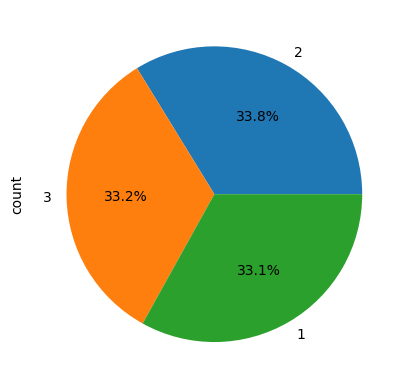

In [7]:
data["Stage"].value_counts().plot.pie(autopct='%1.1f%%');

Rappresentiamo i grafici appartenenti alle feature continue del dataset.

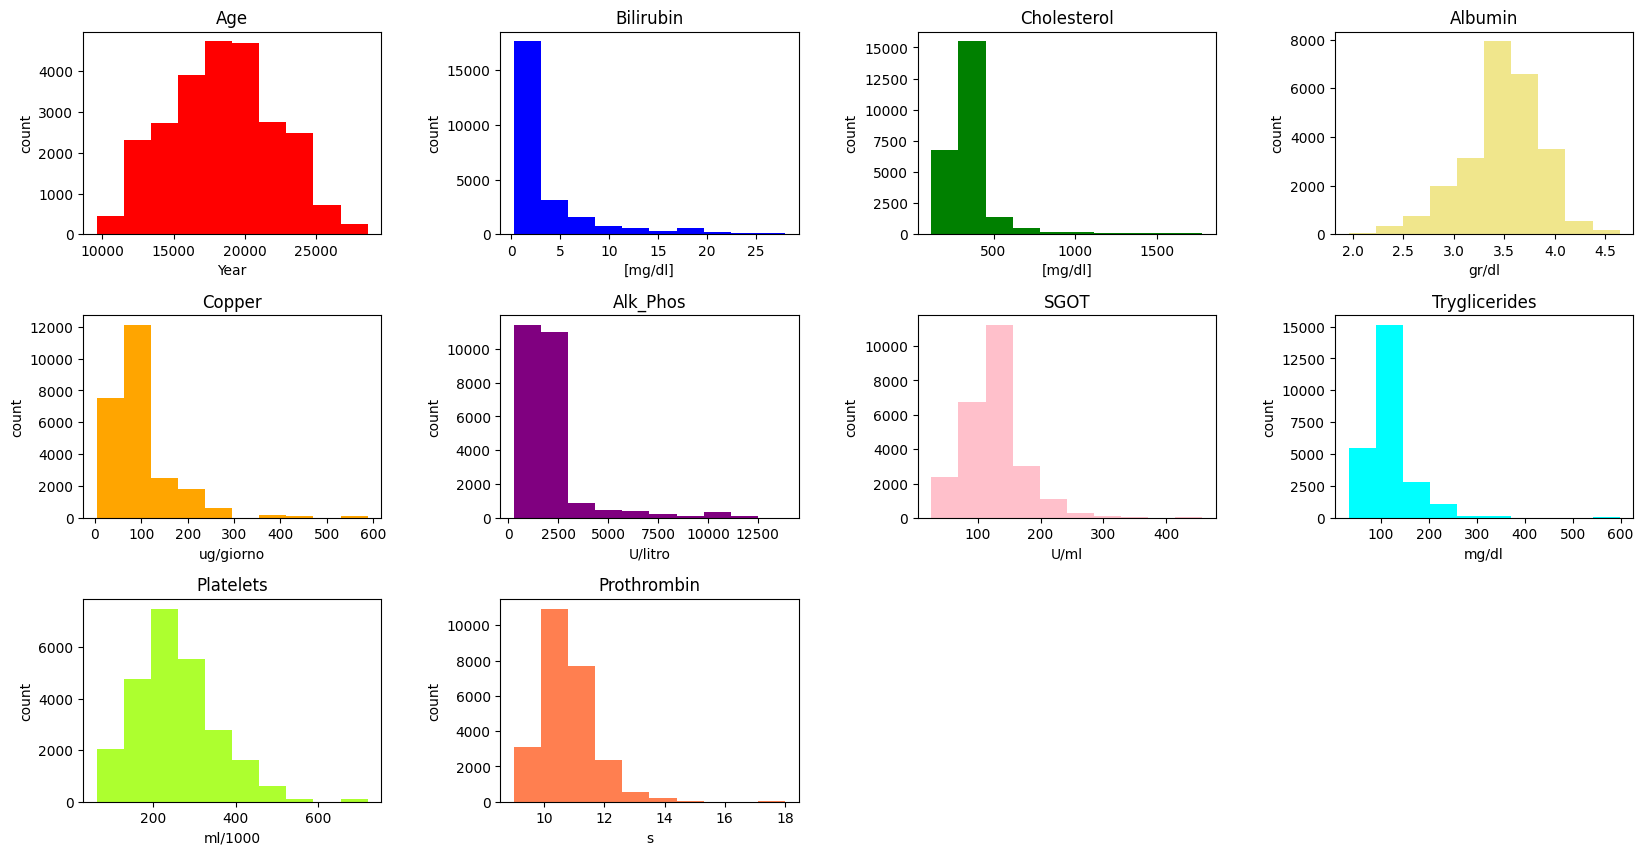

In [8]:
plt.figure(figsize=(20, 10))


plt.subplot(3, 4, 1)
plt.title('Age')
plt.hist(data['Age'], label="Age", color="Red")
plt.ylabel('count')
plt.xlabel('Year')

plt.subplot(3, 4, 2)
plt.title('Bilirubin')
plt.hist(data['Bilirubin'], label="Bilirubin", color="Blue")
plt.ylabel('count')
plt.xlabel('[mg/dl]')

plt.subplot(3, 4, 3)
plt.title('Cholesterol')
plt.hist(data['Cholesterol'], label="Cholesterol", color="Green")
plt.ylabel('count')
plt.xlabel('[mg/dl]')

plt.subplot(3, 4, 4)
plt.title('Albumin')
plt.hist(data['Albumin'], label="Albumin", color="Khaki")
plt.ylabel('count')
plt.xlabel('gr/dl')

plt.subplot(3, 4, 5)
plt.title('Copper')
plt.hist(data['Copper'], label="Copper", color="Orange")
plt.ylabel('count')
plt.xlabel('ug/giorno')

plt.subplot(3, 4, 6)
plt.title('Alk_Phos')
plt.hist(data['Alk_Phos'], label="Alk_Phos", color="Purple")
plt.ylabel('count')
plt.xlabel('U/litro')

plt.subplot(3, 4, 7)
plt.title('SGOT')
plt.hist(data['SGOT'], label="SGOT", color="Pink")
plt.ylabel('count')
plt.xlabel('U/ml')

plt.subplot(3, 4, 8)
plt.title('Tryglicerides')
plt.hist(data['Tryglicerides'], label="Tryglicerides", color="Cyan")
plt.ylabel('count')
plt.xlabel('mg/dl')

plt.subplot(3, 4, 9)
plt.title('Platelets')
plt.hist(data['Platelets'], label="Platelets", color="greenyellow")
plt.ylabel('count')
plt.xlabel('ml/1000')

plt.subplot(3, 4, 10)
plt.title('Prothrombin')
plt.hist(data['Prothrombin'], label="Prothrombin", color="coral")
plt.ylabel('count')
plt.xlabel('s')

plt.subplots_adjust(
                    wspace=0.4,
                    hspace=0.4)

plt.show()

A giudicare dagli istogrammi l'età presenta una quantità maggiore di casi nel range 50-60 anni.
Invece, tranne l'albumina, i valori correlati al sangue si presentano maggiormente nel corretto range che dovrebbero assumere, nonostante ciò, si vede una loro tendenza ad assumere valori che oltrepassano il loro range in eccesso.

Può rilevarsi utile controllare se vi è una correlazione tra l'età e lo stadio della malattia.

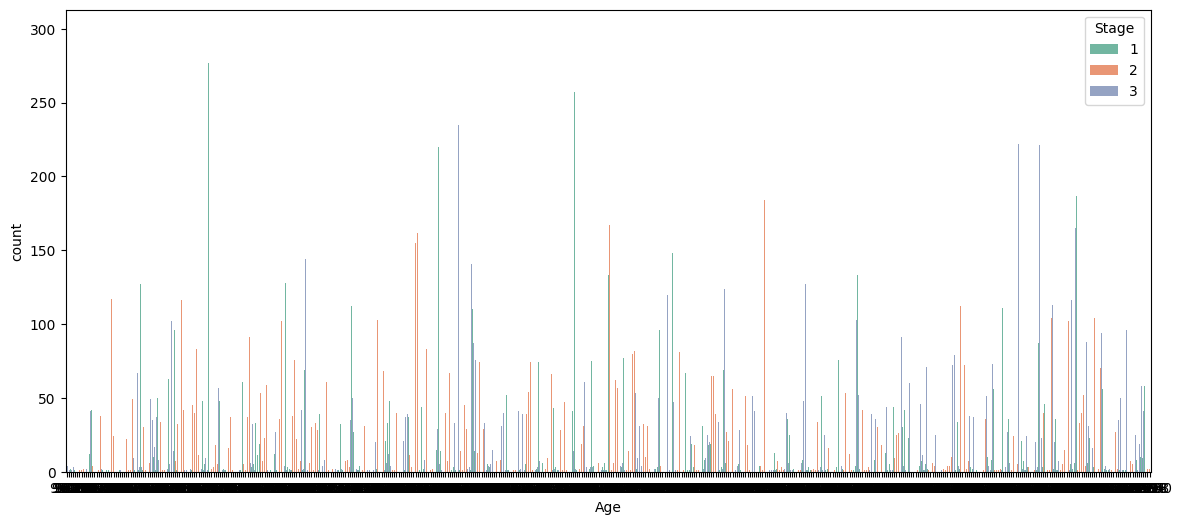

In [9]:
from matplotlib import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 14, 6

sns.countplot(x='Age', hue='Stage', data=data, palette="Set2")
plt.show()

Osservando il grafico può sembrare che l'età non sia particolarmente rilevante e correlata allo stadio delle malattie, nonostante ciò verrà valutata più avanti tale correlazione.
N.B. si presentano più casi per valori "centrali" d'età anche grazie al maggior numero di casi registrati.

##Feature Engineering


###Peso in memoria

In [10]:
data.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Columns: 17 entries, Drug to Stage
dtypes: float64(9), int64(2), object(6)
memory usage: 10.6 MB


Vengono mappate a binarie le feature che assumono solo due valori

In [11]:
#Utility List
features = ['Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema',
       'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
       'Tryglicerides', 'Platelets', 'Prothrombin']
binary_features = ["Ascites", "Hepatomegaly","Spiders","Sex", "Drug"]
categorical_features = ["Edema"]
target = ["Stage"]

In [12]:
sex_mapping = {"M":0,"F":1}
yes_no_mapping = {"N":0,"Y":1}
drug_mapping = {"Placebo":0,"D-penicillamine":1}

data["Sex"] = data["Sex"].map(sex_mapping)
data["Ascites"] = data["Ascites"].map(yes_no_mapping)
data["Hepatomegaly"] = data["Hepatomegaly"].map(yes_no_mapping)
data["Spiders"] = data["Spiders"].map(yes_no_mapping)
data["Drug"] = data["Drug"].map(drug_mapping)

Vengono attribuite alle feature i tipi più consoni.

In [13]:
for feature in binary_features:
  data[feature] = data[feature].astype(bool)

data["Edema"] = data["Edema"].astype("category")

Infine per comodità è stato deciso di esprimere l'età dei pazienti in anni approssimandola.

In [14]:
data["Age"] = round(data["Age"]/365, 0)
data["Age"] = data["Age"].astype(int)

In [15]:
data.head(1)

,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,False,51,True,False,True,False,N,0.5,149.0,4.04,227.0,598.0,52.7,57.0,256.0,9.9,1


Si è così ottenuto un dataset che pesa circa un terzo di quello inizialmente importato.

In [16]:
data.info(verbose=False,memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Columns: 17 entries, Drug to Stage
dtypes: bool(5), category(1), float64(9), int64(2)
memory usage: 2.2 MB


###Valori nulli
Si ricerca se nel database sono presenti valori nulli che in caso verranno trattati.

Nel nostro caso non sono presenti.

In [17]:
data.isna().sum()

Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

###Trattamento feature categoriche

Viene presa la feature categorica e si crea una colonna per ogni valore assumibile da tale feature.
In base al valore assunto sarà presente un 1 nella colonna corrispondente.

In [18]:
data = pd.get_dummies(data, columns=categorical_features, prefix=categorical_features)

In [19]:
data.head(1)

,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Edema_N,Edema_S,Edema_Y
0,False,51,True,False,True,False,0.5,149.0,4.04,227.0,598.0,52.7,57.0,256.0,9.9,1,True,False,False


Esempio: se la colonna `Edema` di un osservazione assumeva valore S, allora saranno settate così le nuove colonne: `Edema_N`=0, `Edema_S`=1,  `Edema_Y`=0

##Modelli di classificazione

Verranno di seguito utilizzate varie tipologie di modelli di classificazione mostrandone l'efficienza.
Soltanto alla fine, su di essi, verrà fatta la riflessione adeguata.

N.B. ogni modello viene usato insieme ad un filtro di standardizzazione visto che le feature del dataset sono rappresentate da scale diverse.

Divisione del dataset in train set e in validation set

In [20]:
X = data.drop(columns="Stage")
y = data["Stage"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

Viene definita una funzione che sarà utilizzata per valutare se il modello addestrato presenta o no overfitting.
Non essendoci una soglia fissata è stato deciso, vista la "ridotta" misura del dataset, che, il modello è in overfitting se:

`model.score(test_set) - model.score(validation) > 5%`




In [21]:
def model_in_overfitting(model, X_train, X_val, y_train, y_val):
  test_score = model.score(X_train,y_train)
  val_score = model.score(X_val, y_val)
  return (test_score - val_score) > 0.05

###Perceptron

Si inizia utilizzando il modello più semplice. Esso è basato sulla capacità di trovare un iperpiano che divida due classi tra di loro. Se si ha un problema multiclasse viene utilizzata la tecnica OvA(One vs All) dove si usano più iperpiani
 separatori ciascuno allenato a riconoscere una specifica classe.


In [22]:
perceptron_model = Pipeline([
    ("scaler", StandardScaler()),
    ("perceptron", Perceptron())
])

Si cercano tramite la gridsearch gli iperparametri ottimali tra quelli che è stato deciso di inserire.

In [23]:
grid = [
    {
        "scaler": [None, StandardScaler()],
        "perceptron__penalty": ["l2", "l1"],
        "perceptron__alpha": [0.0001, 0.001, 0.01, 1],
    },
    {
        "scaler": [None, StandardScaler()],
        "perceptron__penalty": ["elasticnet"],
        "perceptron__alpha": [0.0001, 0.001, 0.01, 1],
        "perceptron__l1_ratio": [0.2, 0.5] #l1_ratio ha senso solo nel momento in cui si sceglie una penalty elasticnet
    }
]

In [24]:
gs_perceptron = GridSearchCV(perceptron_model, param_grid=grid, cv=5, n_jobs=-1)

In [25]:
gs_perceptron.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('perceptron', Perceptron())]),
             n_jobs=-1,
             param_grid=[{'perceptron__alpha': [0.0001, 0.001, 0.01, 1],
                          'perceptron__penalty': ['l2', 'l1'],
                          'scaler': [None, StandardScaler()]},
                         {'perceptron__alpha': [0.0001, 0.001, 0.01, 1],
                          'perceptron__l1_ratio': [0.2, 0.5],
                          'perceptron__penalty': ['elasticnet'],
                          'scaler': [None, StandardScaler()]}])

In [26]:
print('Score migliore: {:.4f}%'.format(round(gs_perceptron.best_score_ * 100, 4)))
print('\nParametri migliori:')
print(pd.Series(gs_perceptron.best_params_))

print('\nOverfitting: ', model_in_overfitting(gs_perceptron, X_train, X_val, y_train, y_val))

Score migliore: 49.7537%

Parametri migliori:
perceptron__alpha                  0.001
perceptron__l1_ratio                 0.5
perceptron__penalty           elasticnet
scaler                  StandardScaler()
dtype: object

Overfitting:  False


In [27]:
#Servirà in fase di valutazione
best_perceptron_model = Pipeline([
    ("scaler", StandardScaler()),
    ("perceptron", Perceptron(alpha=0.001, penalty="elasticnet", l1_ratio=0.5))
])
best_perceptron_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('perceptron',
                 Perceptron(alpha=0.001, l1_ratio=0.5, penalty='elasticnet'))])

###Logistic Regression

La regressione logistica è un algoritmo di classificazione binaria che utilizza la funzione logistica per calcolare le probabilità di appartenenza delle osservazioni alle classi. A differenza del perceptron, la regressione logistica produce probabilità predette anziché decisioni categoriche

In [28]:
lr_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver="saga", random_state=42))
])

Si cercano tramite la gridsearch gli iperparametri ottimali tra quelli che è stato deciso di inserire.

In [29]:
grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l1", "l2"],
        "lr__C": [0.1, 1, 3, 5, 10]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["elasticnet"],
        "lr__C": [0.1, 1, 3, 5, 10],
        "lr__l1_ratio": [0.2, 0.5]
    }
]

In [30]:
gs_lr = GridSearchCV(lr_model, param_grid=grid, cv=5, n_jobs=-1)

In [31]:
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid=[{'lr__C': [0.1, 1, 3, 5, 10],
                          'lr__penalty': ['l1', 'l2'],
                          'scaler': [None, StandardScaler()]},
                         {'lr__C': [0.1, 1, 3, 5, 10],
                          'lr__l1_ratio': [0.2, 0.5],
                          'lr__penalty': ['elasticnet'],
                          'scaler': [None, StandardScaler()]}])

In [32]:
print('Score migliore: {:.4f}%'.format(round(gs_lr.best_score_ * 100, 4)))
print('\nParametri migliori:')
print(pd.Series(gs_lr.best_params_))
print('\nOverfitting: ', model_in_overfitting(gs_lr, X_train, X_val, y_train, y_val))

Score migliore: 57.7043%

Parametri migliori:
lr__C                       0.1
lr__penalty                  l2
scaler         StandardScaler()
dtype: object

Overfitting:  False


In [33]:
#Servirà in fase di valutazione
best_lr_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver="saga", random_state=42, C=0.1, penalty="l2"))
])
best_lr_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(C=0.1, random_state=42, solver='saga'))])

###SVM

Il Support Vector Machines è un modello che sfrutta i Support Vector, ovvero quegli elementi che sono situati ai "bordi" dei confini della propria classe, permettendo all'algoritmo di ricercare l'iperpiano che massima la distanza da sè stesso e due diverse classi.

In [34]:
svm_model = Pipeline([
    ("std", StandardScaler()),
    ("svm", SVC())
])

Si cercano tramite la gridsearch gli iperparametri ottimali tra quelli che è stato deciso di inserire.

In [35]:
grid = {
    "svm__gamma" : [0.1, 1, 5],
    "svm__C" : [1, 5],
    "svm__kernel" : ['rbf']
}

In [36]:
gs_svm = GridSearchCV(svm_model, param_grid=grid, cv=5, n_jobs=-1)

In [37]:
gs_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [1, 5], 'svm__gamma': [0.1, 1, 5],
                         'svm__kernel': ['rbf']})

In [38]:
print('Score migliore: {:.4f}%'.format(round(gs_svm.best_score_ * 100, 4)))

print('\nParametri migliori:')
print(pd.Series(gs_svm.best_params_))
print('\nOverfitting: ', model_in_overfitting(gs_svm, X_train, X_val, y_train, y_val))

Score migliore: 89.2896%

Parametri migliori:
svm__C           5
svm__gamma       1
svm__kernel    rbf
dtype: object

Overfitting:  True


Visto il risultato ottenuto, è stato valutato (in un altro notebook) che la soluzione migliore senza che si registri un caso di overfitting è con gli iperparametri utilizzati nella seguente cella.

In [39]:
svm_no_of = Pipeline([
    ("std", StandardScaler()),
    ("svm", SVC(C=1, gamma=0.1, kernel="rbf"))
])
svm_no_of.fit(X_train, y_train)
print('Score: {:.4f}%'.format(round(svm_no_of.score(X_train, y_train) * 100, 4)))
print('\nOverfitting: ', model_in_overfitting(svm_no_of, X_train, X_val, y_train, y_val))

Score: 86.3555%

Overfitting:  False


###Albero decisionale



Un albero decisionale è un algoritmo di apprendimento supervisionato che suddivide iterativamente i dati in gruppi omogenei basandosi su criteri di separazione. Ciascun nodo interno rappresenta una decisione basata su una caratteristica dei dati, mentre le foglie rappresentano le etichette di classificazione.

In [40]:
tree_model = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier())
])

Si cercano tramite la gridsearch gli iperparametri ottimali tra quelli che è stato deciso di inserire.

In [41]:
grid = {
    "tree__max_depth" : [8, 10, 12],
    "tree__min_samples_split" : [2, 5, 10],
    "tree__min_samples_leaf": [1, 2, 4],
}

In [42]:
gs_tree = GridSearchCV(tree_model, param_grid=grid, cv=5, n_jobs=-1)

In [43]:
gs_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('tree', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [8, 10, 12],
                         'tree__min_samples_leaf': [1, 2, 4],
                         'tree__min_samples_split': [2, 5, 10]})

In [44]:
print('Score migliore: {:.4f}%'.format(round(gs_tree.best_score_ * 100, 4)))
print('\nParametri migliori:')
print(pd.Series(gs_tree.best_params_))
print('\nOverfitting: ', model_in_overfitting(gs_tree, X_train, X_val, y_train, y_val))

Score migliore: 84.7295%

Parametri migliori:
tree__max_depth            12
tree__min_samples_leaf      1
tree__min_samples_split     2
dtype: int64

Overfitting:  False


###LightGBM

LightGBM è un'implementazione efficiente e scalabile di alberi decisionali potenziata dal gradient boosting framework. Si basa su una strategia di apprendimento basata su gradienti, costruendo alberi decisionali in modo incrementale e concentrandosi sui campioni più difficili da classificare o da predire. Ciò rende LightGBM particolarmente adatto per grandi dataset e problemi complessi.

In [45]:
lgbm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lgbm", LGBMClassifier(objective='multiclass',num_class=3))
])

Si cercano tramite la gridsearch gli iperparametri ottimali tra quelli che è stato deciso di inserire.

In [46]:
grid = {
    "lgbm__learning_rate":[0.05, 0.01],
    "lgbm__max_depth":[10, 15],
    "lgbm__num_leaves":[31],
    "lgbm__boosting_type" : ["gbdt"],
}

In [47]:
gs_lgbm = GridSearchCV(lgbm_model, param_grid=grid, cv=5, n_jobs=-1)

In [48]:
gs_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1572
[LightGBM] [Info] Number of data points in the train set: 16666, number of used features: 18
[LightGBM] [Info] Start training from score -1.108441
[LightGBM] [Info] Start training from score -1.094540
[LightGBM] [Info] Start training from score -1.092928


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lgbm',
                                        LGBMClassifier(num_class=3,
                                                       objective='multiclass'))]),
             n_jobs=-1,
             param_grid={'lgbm__boosting_type': ['gbdt'],
                         'lgbm__learning_rate': [0.05, 0.01],
                         'lgbm__max_depth': [10, 15],
                         'lgbm__num_leaves': [31]})

In [49]:
print('Score migliore: {:.4f}%'.format(round(gs_lgbm.best_score_ * 100, 4)))
print('\nParametri migliori:')
print(pd.Series(gs_lgbm.best_params_))
print('\nOverfitting: ', model_in_overfitting(gs_lgbm, X_train, X_val, y_train, y_val))

Score migliore: 93.3697%

Parametri migliori:
lgbm__boosting_type    gbdt
lgbm__learning_rate    0.05
lgbm__max_depth          15
lgbm__num_leaves         31
dtype: object
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

Overfitting:  False


##Valutazione dei modelli

I modelli vengono ora valutati tramite i seguenti metodi:
- Matrice di confusione
- Precision, Recall, F1
- Intervallo di confidenza
- Test di McNemar

###Matrice di confusione

Fornisce una rappresentazione tabellare delle previsioni di un modello rispetto alle vere etichette di classe presenti nei dati di test.


In [50]:
def print_confusion_matrix(model, X_val, y_val):
    matrix = confusion_matrix(y_val, model.predict(X_val))
    display(pd.DataFrame(matrix, index=[1,2,3], columns=[1,2,3]))
    return

In [51]:
BOLD = "\033[1m"
END_BOLD = "\033[0m"

print(BOLD + "Perceptron model confusion matrix" + END_BOLD)
print_confusion_matrix(gs_perceptron, X_val, y_val)

print(BOLD + "\n\nLogistic Regression model confusion matrix" + END_BOLD)
print_confusion_matrix(gs_lr, X_val, y_val)

print(BOLD + "\n\nSVM model confusion matrix" + END_BOLD)
print_confusion_matrix(svm_no_of, X_val, y_val)

print(BOLD + "\n\nDecision tree model confusion matrix" + END_BOLD)
print_confusion_matrix(gs_tree, X_val, y_val)

print(BOLD + "\n\nLightGBM model confusion matrix" + END_BOLD)
print_confusion_matrix(gs_lgbm, X_val, y_val)

Perceptron model confusion matrix


,1,2,3
1,361,1745,658
2,231,1805,827
3,109,720,1878




Logistic Regression model confusion matrix


,1,2,3
1,1682,681,401
2,963,1281,619
3,368,402,1937




SVM model confusion matrix


,1,2,3
1,2274,381,109
2,348,2351,164
3,171,207,2329




Decision tree model confusion matrix


,1,2,3
1,2238,453,73
2,173,2572,118
3,96,304,2307




LightGBM model confusion matrix
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,1,2,3
1,2562,155,47
2,95,2687,81
3,56,95,2556


Le istanze classificate correttamente sono quelle contate lungo la diagonale della matrice, si può notare ad occhio come i modelli confondano maggiormente tra di loro le istanze 1 e 2.
Probabilmente questo si verifica perchè nei dati le classi 1 e 2 si sovrappongono maggiormente.

###precision - recall - f1

- **Precision** è l’accuratezza con cui il sistema di machine learning prevede le classi positive.
Non è sempre la migliore daconsiderare visto che considera solo le previsioni positive.

- **Recall** indica il rapporto di istanze positive correttamente individuate dal modello.

- **F1** è la media armonica delle due precedenti.
Rispetto ad una media convenzionale, quella armonica attribuisce un peso maggiore ai valori piccoli. Questò fa sì che un classificatore ottenga un alto punteggio F1 solo quando precisione e recupero sono entrambi alti.

In [52]:
def calculate_precision_recall_f1(model, X_val, y_val):
    y_pred = model.predict(X_val)
    p = precision_score(y_val, y_pred, pos_label=1, average="macro")
    r = recall_score(y_val, y_pred, average="macro")
    f1 = f1_score(y_val, y_pred, average="macro")
    return {"precision" : p, "recall": r, "f1-score": f1}

In [53]:
display(
    pd.DataFrame([calculate_precision_recall_f1(gs_perceptron, X_val, y_val),
                  calculate_precision_recall_f1(gs_lr, X_val, y_val),
                  calculate_precision_recall_f1(svm_no_of, X_val, y_val),
                  calculate_precision_recall_f1(gs_tree, X_val, y_val),
                  calculate_precision_recall_f1(gs_lgbm, X_val, y_val)],
                  index=["Perceptron", "Logistic Regression", "SVM", "Decisional Tree", "LightGBM"])
    )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,precision,recall,f1-score
Perceptron,0.498708,0.484941,0.444416
Logistic Regression,0.585061,0.590508,0.585475
SVM,0.836397,0.834750,0.835405
Decisional Tree,0.862948,0.853430,0.855460
LightGBM,0.937177,0.936554,0.936782


Il modello di classificcazione più preciso è decisamente **LightGBM**.

###Intervalli di confidenza

Verrà utilizzato un intervallo di confidenza al 95%.
Ciò significa che al 95% l'accuratezza del modello considerato rientrerà in un range [inf, sup]

In [54]:
#credit: https://nbviewer.org/urls/bitbucket.org/volpepe/whats-cooking-challenge/raw/777f42bd4905f478c28b449d05cd2f9c51af94c9/Progetto.ipynb

def confidence(acc, N, Z):
    den = (2*(N+Z**2))
    var = (Z*np.sqrt(Z**2+4*N*acc-4*N*acc**2)) / den
    a = (2*N*acc+Z**2) / den
    inf = a - var
    sup = a + var
    return (inf, sup)

def calculate_accuracy(model, X_val, y_val):
    matrix = confusion_matrix(y_val, model.predict(X_val))
    conf_matrix = pd.DataFrame(matrix, index=[1,2,3], columns=[1,2,3])
    return np.diag(conf_matrix).sum() / conf_matrix.sum().sum()

In [55]:
display(pd.DataFrame([confidence(calculate_accuracy(gs_perceptron, X_val, y_val), len(X_val), 1.96),
                      confidence(calculate_accuracy(gs_lr, X_val, y_val), len(X_val), 1.96),
                      confidence(calculate_accuracy(svm_no_of, X_val, y_val), len(X_val), 1.96),
                      confidence(calculate_accuracy(gs_tree, X_val, y_val), len(X_val), 1.96),
                      confidence(calculate_accuracy(gs_lgbm, X_val, y_val), len(X_val), 1.96),],
                      index=["Perceptron", "Logistic Regression", "SVM", "Decisional Tree", "LightGBM"], columns=["inf", "sup"]))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,inf,sup
Perceptron,0.474520,0.495976
Logistic Regression,0.577347,0.598478
SVM,0.826279,0.842239
Decisional Tree,0.846227,0.861390
LightGBM,0.931087,0.941561


Come era ormai intuibile ancora una volta il modello più performante rimane LightGBM.

###Test di McNemar

E' un test sattistico che può essere utilizzato per confrontare l'accuratezza predittiva di due modelli. Potendo quindi dire se due modelli sono statisticamente simili nel fare previsioni.

In [56]:
def McNemar_test(model1, model2, X_val, y_val):
    #Creating contingency table
    y_target = y_val
    y_model1 = model1.predict(X_val)
    y_model2 = model2.predict(X_val)

    tb = mcnemar_table(y_target=y_target,
                       y_model1=y_model1,
                       y_model2=y_model2)

    chi2, p = mcnemar(tb)

    confidence = 0.95
    alpha = 1 - confidence

    print("chi^2:", chi2, "   -   p:", p)

    if(p > alpha):
      print("Modelli equivalenti")
    else:
      print("Modelli non equivalenti")


In [57]:
def McNemar_beetween_all_models(models, models_name):
  for i in range(len(models)):
    for j in range(i+1, len(models)):
      print(BOLD,models_name[i], " - ", models_name[j], END_BOLD +"\n")
      McNemar_test(models[i], models[j], X_val, y_val)
      print("\n\n")

In [58]:
models=[gs_perceptron, gs_lr, svm_no_of, gs_tree, gs_lgbm]
models_name=["Perceptron","Logistic Regression"," SVM","Decisional Tree","LightGBM"]

In [59]:
McNemar_beetween_all_models(models, models_name)

 Perceptron  -  Logistic Regression 

chi^2: 277.9562737642586    -   p: 2.0939447657747037e-62
Modelli non equivalenti



 Perceptron  -   SVM 

chi^2: 2268.7080428954423    -   p: 0.0
Modelli non equivalenti



 Perceptron  -  Decisional Tree 

chi^2: 2501.2414524251258    -   p: 0.0
Modelli non equivalenti



 Perceptron  -  LightGBM 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
chi^2: 3503.742255266419    -   p: 0.0
Modelli non equivalenti



 Logistic Regression  -   SVM 

chi^2: 1413.4168343393696    -   p: 2.552303501082906e-309
Modelli non equivalenti



 Logistic Regression  -  Decisional Tree 

chi^2: 1559.4334709431566    -   p: 0.0
Modelli non equivalenti



 Logistic Regression  -  LightGBM 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
chi^2: 2664.523222748815    -   p: 0.0
Modelli non equivalenti



  S

Dai risultati del test di McNemar condotto su diversi modelli di classificazione, emerge una tendenza: in tutti i confronti, i modelli sono risultati significativamente diversi.
Indicando così una differenza significativa nelle performance dei modelli di classificazione confrontati.

##Conclusioni

In conclusione si pone l'attenzione sulle differenze significative tra i vari modelli di classificazione multiclasse.
<br>Perceptron e logistic regression, essendo modelli lineari, potrebbero non essere stati in grado di catturare in maniera ottimale le relazioni non lineari presenti nei dati. Questo ha limitato la loro capacità di adattarsi a complessità maggiori nei dati di training, portando a prestazioni inferiori rispetto agli altri modelli.
<br>SVM, decision tree e Lightgbm, invece, offrono maggiore flessibilità nel modellare relazioni complesse tra le features, permettendo una migliore adattabilità ai dati di training e, di conseguenza, prestazioni più elevate.
<br>In particolare, Lightgbm, essendo un algoritmo di boosting, può sfruttare efficacemente le caratteristiche dei dati e ottenere prestazioni superiori grazie alla sua capacità di gestire grandi dataset a complessità elevata.